In [1]:
import numpy as np
import preprocessing as pp

from graph import *
from bayesian_decision_evaluation import *

import models
from models.multivariate_gaussian_classifier import *


In [2]:
X, y = utils.load_data()

classes = {
    'Fake': 'blue',
    'Real': 'orange'
}

In [3]:
y1 = np.count_nonzero(y == 1)
y0 = np.count_nonzero(y == 0)

print('Number of samples in class 0:', y0)
print('Number of samples in class 1:', y1)

Number of samples in class 0: 2990
Number of samples in class 1: 3010


#### Analyze the performance of the MVG classifier and its variants for different applications.
Start considering five applications, given by (π1,Cfn,Cfp):

In [4]:

def print_prior_prob(pi, cost_fp, cost_fn):
    cost_matrix, prior_class_prob, threshold = binary_cost_matrix(pi, cost_fp, cost_fn)
    print(f"pi: {pi}, prior_class_prob: {prior_class_prob}, cost_fp: {cost_fp}, cost_fn: {cost_fn}, threshold: {threshold:.4f}")
    print(f"Cost matrix:")
    for i in range(cost_matrix.shape[0]):
        print(f"\t{cost_matrix[i]}")
    print()

print_prior_prob(0.5, 1, 1)
print_prior_prob(0.9, 1, 1)
print_prior_prob(0.1, 1, 1)
print_prior_prob(0.5, 1, 9)
print_prior_prob(0.5, 9, 1)

pi: 0.5, prior_class_prob: [0.5 0.5], cost_fp: 1, cost_fn: 1, threshold: -0.0000
Cost matrix:
	[0 1]
	[1 0]

pi: 0.9, prior_class_prob: [0.1 0.9], cost_fp: 1, cost_fn: 1, threshold: -2.1972
Cost matrix:
	[0 1]
	[1 0]

pi: 0.1, prior_class_prob: [0.9 0.1], cost_fp: 1, cost_fn: 1, threshold: 2.1972
Cost matrix:
	[0 1]
	[1 0]

pi: 0.5, prior_class_prob: [0.5 0.5], cost_fp: 1, cost_fn: 9, threshold: -2.1972
Cost matrix:
	[0 9]
	[1 0]

pi: 0.5, prior_class_prob: [0.5 0.5], cost_fp: 9, cost_fn: 1, threshold: 2.1972
Cost matrix:
	[0 1]
	[9 0]



For each application, compute the optimal Bayes decisions for the validation set for the MVG models and its variants, with and without PCA (try different values of m). Compute DCF (actual) and minimum DCF for the different models. Compare the models in terms of minimum DCF. 

In [5]:
def compute_statistics(llr, y_true, pi, C_fp=1, C_fn=1, unique_labels=None, plot_graph=False):
    cost_matrix, prior_class_prob, threshold = binary_cost_matrix(pi, C_fp, C_fn)
    
    minDCF, best_threshold = compute_minDCF(llr, y_true, pi, unique_labels)
    
    y_pred = np.where(llr > threshold, 1, 0)
    y_pred_best = np.where(llr > best_threshold, 1, 0)
    cm_best = confusion_matrix(y_true, y_pred_best)
    cm = confusion_matrix(y_true, y_pred)
    DCF, _, _ = compute_DCF(cm, cost_matrix, prior_class_prob)
    DCF_norm, _, _ = compute_DCF_normalized(cm, cost_matrix, prior_class_prob)
    acc = accuracy(cm_best)
    
    print(f"\tminDCF: {minDCF:.4f}, DCf: {DCF:.4f}, DCF_norm: {DCF_norm:.4f}, accuracy: {acc*100:.2f}%, threshold: {best_threshold:.4f}")
    print()
    if plot_graph:
        plot_ROC_curve(llr, y_true, cost_matrix, prior_class_prob, unique_labels)
        plot_bayes_error(llr, y_true, unique_labels)
    
    return minDCF, acc

In [6]:
def compute_accuracy(llr, prior, y_true, unique_labels=None, th_req=False):
    if unique_labels is None:
        unique_labels = np.unique(y_true)

    _, threshold = compute_minDCF(llr, y_true, prior, unique_labels)
    y_pred = np.where(llr > threshold, unique_labels[1], unique_labels[0])
    cm = confusion_matrix(y_true, y_pred)
    
    acc = accuracy(cm)
    if th_req:
        return acc, threshold
    return acc

In [7]:
models_dict = {
    'MVG': MultivariateGaussianClassifier(),
    'NB': NaiveBayesClassifier(),
    'TC': TiedCovarianceClassifier(),
}

#### Raw data

In [8]:
X_train, y_train, X_test, y_test = utils.split_data(X, y)
pie = [0.1, 0.5, 0.9]
Applications = [[0.5, 1.0, 1.0], [0.9, 1.0, 1.0], [0.1, 1.0, 1.0], [0.5, 1.0, 9.0], [0.5, 9.0, 1.0]]

for pi, C_fp, C_fn in Applications:
    print(f"Prior probability: {pi}, C_fp: {C_fp}, C_fn: {C_fn}")
    for model_name, model in models_dict.items():
        print(f"\tModel: {model_name}")
        model.set_prior(pi)
        model.fit(X_train, y_train)
        llr = model.score_binary(X_test, y)
        
        compute_statistics(llr, y_test, pi, C_fp, C_fn, unique_labels=np.unique(y))

# for pi in pie:
#     print(f"Prior probability: {pi}")
#     for model_name, model in models_dict.items():
#         print(f"\tModel: {model_name}")
#         model.set_prior(pi)
#         model.fit(X_train, y_train)
#         llr = model.score_binary(X_test, y)
        
#         compute_statistics(llr, y_test, pi, unique_labels=np.unique(y))

Prior probability: 0.5, C_fp: 1.0, C_fn: 1.0
	Model: MVG
	minDCF: 0.1302, DCf: 0.0700, DCF_norm: 0.1399, accuracy: 93.50%, threshold: -0.2233

	Model: NB
	minDCF: 0.1311, DCf: 0.0720, DCF_norm: 0.1439, accuracy: 93.45%, threshold: -0.1791

	Model: TC
	minDCF: 0.1812, DCf: 0.0930, DCF_norm: 0.1860, accuracy: 90.95%, threshold: -0.2238

Prior probability: 0.9, C_fp: 1.0, C_fn: 1.0
	Model: MVG
	minDCF: 0.3423, DCf: 0.0400, DCF_norm: 0.4001, accuracy: 89.70%, threshold: -1.6198

	Model: NB
	minDCF: 0.3510, DCf: 0.0389, DCF_norm: 0.3893, accuracy: 90.45%, threshold: -1.4079

	Model: TC
	minDCF: 0.4421, DCf: 0.0463, DCF_norm: 0.4626, accuracy: 84.75%, threshold: -2.0126

Prior probability: 0.1, C_fp: 1.0, C_fn: 1.0
	Model: MVG
	minDCF: 0.2629, DCf: 0.0305, DCF_norm: 0.3051, accuracy: 89.60%, threshold: 1.5372

	Model: NB
	minDCF: 0.2570, DCf: 0.0302, DCF_norm: 0.3022, accuracy: 89.90%, threshold: 1.5281

	Model: TC
	minDCF: 0.3628, DCf: 0.0406, DCF_norm: 0.4061, accuracy: 86.60%, threshold: 

In [9]:
for pi in pie:
    print(f"Prior probability: {pi}")
    for model_name, model in models_dict.items():
        print(f"\tModel: {model_name}")
        model.set_prior(pi)
        model.fit(X_train, y_train)
        llr = model.score_binary(X_test, y)

        compute_statistics(llr, y_test, pi, unique_labels=np.unique(y))

Prior probability: 0.1
	Model: MVG
	minDCF: 0.2629, DCf: 0.0305, DCF_norm: 0.3051, accuracy: 89.60%, threshold: 1.5372

	Model: NB
	minDCF: 0.2570, DCf: 0.0302, DCF_norm: 0.3022, accuracy: 89.90%, threshold: 1.5281

	Model: TC
	minDCF: 0.3628, DCf: 0.0406, DCF_norm: 0.4061, accuracy: 86.60%, threshold: 1.7163

Prior probability: 0.5
	Model: MVG
	minDCF: 0.1302, DCf: 0.0700, DCF_norm: 0.1399, accuracy: 93.50%, threshold: -0.2233

	Model: NB
	minDCF: 0.1311, DCf: 0.0720, DCF_norm: 0.1439, accuracy: 93.45%, threshold: -0.1791

	Model: TC
	minDCF: 0.1812, DCf: 0.0930, DCF_norm: 0.1860, accuracy: 90.95%, threshold: -0.2238

Prior probability: 0.9
	Model: MVG
	minDCF: 0.3423, DCf: 0.0400, DCF_norm: 0.4001, accuracy: 89.70%, threshold: -1.6198

	Model: NB
	minDCF: 0.3510, DCf: 0.0389, DCF_norm: 0.3893, accuracy: 90.45%, threshold: -1.4079

	Model: TC
	minDCF: 0.4421, DCf: 0.0463, DCF_norm: 0.4626, accuracy: 84.75%, threshold: -2.0126



In [10]:
for model_name, model in models_dict.items():
    print(f"Model: {model_name}")
    model.fit(X_train, y_train)
    llr = model.score_binary(X_test, y)
    acc, threshold = compute_accuracy(llr, 0.5, y_test, th_req=True)
    print(f"\tAccuracy: {acc*100:.2f}%, threshold: {threshold:.4f}")

Model: MVG
	Accuracy: 93.50%, threshold: -0.2233
Model: NB
	Accuracy: 93.45%, threshold: -0.1791
Model: TC
	Accuracy: 90.95%, threshold: -0.2238


#### PCA data

In [11]:
def compute_accuracy_model_pca(X_train, y_train, X_test, y_test, models, pi):
    results = {model_name: [] for model_name in models.keys()}
    
    for i in reversed(range(X_train.shape[0])):
        X_train_pca, eig_v = pp.pca(data=X_train, n_features=i+1, required_eigen_vectors=True)
        X_test_pca = np.dot(eig_v.T, X_test)
        
        for model_name, model in models.items():
            print(f"Model: {model_name}, PCA features: {i+1}")
            model.fit(X_train_pca, y_train)
            llr = model.score_binary(X_test_pca, y_test)
            minDCF, acc = compute_statistics(llr, y_test, pi)
            results[model_name].append((i+1, acc, minDCF))
    
    plt.figure(figsize=(10, 6))
    
    for model_name, acc in results.items():
        features, accuracies, dcfs = zip(*acc)
        plt.plot(features, dcfs, marker='o', label=model_name)
        
    plt.xlabel('Number of PCA features')
    plt.ylabel('min DCFs')
    plt.title('Model min DCF values with Varying PCA Features')
    plt.legend()
    plt.grid(True)
    plt.gca()
    plt.show()
    
    return results

Model: MVG, PCA features: 6
	minDCF: 0.2629, DCf: 0.0305, DCF_norm: 0.3051, accuracy: 89.60%, threshold: 1.5372

Model: NB, PCA features: 6
	minDCF: 0.3535, DCf: 0.0392, DCF_norm: 0.3920, accuracy: 85.85%, threshold: 1.8433

Model: TC, PCA features: 6
	minDCF: 0.3628, DCf: 0.0406, DCF_norm: 0.4061, accuracy: 86.60%, threshold: 1.7163

Model: MVG, PCA features: 5
	minDCF: 0.2738, DCf: 0.0304, DCF_norm: 0.3041, accuracy: 89.05%, threshold: 1.6363

Model: NB, PCA features: 5
	minDCF: 0.3545, DCf: 0.0393, DCF_norm: 0.3930, accuracy: 85.80%, threshold: 1.8704

Model: TC, PCA features: 5
	minDCF: 0.3648, DCf: 0.0405, DCF_norm: 0.4051, accuracy: 86.50%, threshold: 1.7285

Model: MVG, PCA features: 4
	minDCF: 0.3012, DCf: 0.0353, DCF_norm: 0.3529, accuracy: 89.30%, threshold: 1.4257

Model: NB, PCA features: 4
	minDCF: 0.3614, DCf: 0.0397, DCF_norm: 0.3970, accuracy: 85.45%, threshold: 1.9132

Model: TC, PCA features: 4
	minDCF: 0.3610, DCf: 0.0403, DCF_norm: 0.4031, accuracy: 87.10%, threshol

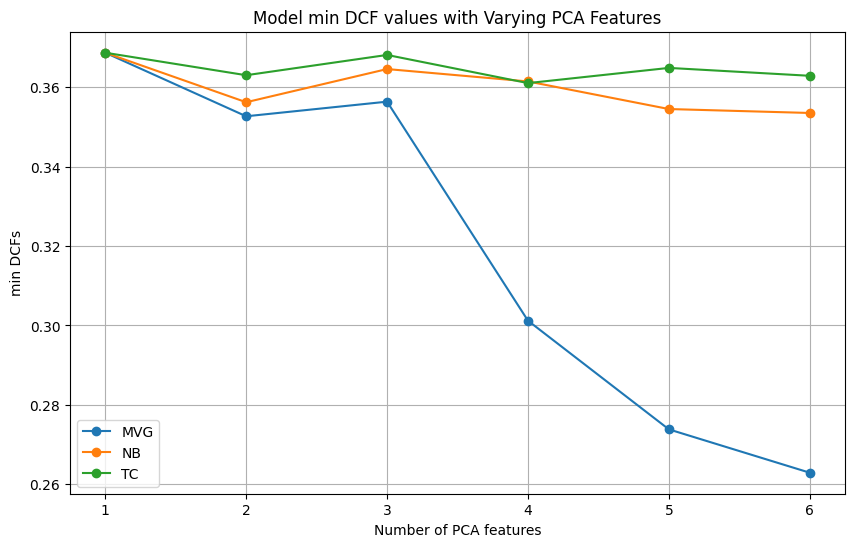

MVG - Best Accuracy: (6, 0.896, 0.2629128264208909)
NB - Best Accuracy: (2, 0.8775, 0.35618279569892475)
TC - Best Accuracy: (3, 0.8715, 0.3680875576036866)


In [12]:
pi = 0.1
res = compute_accuracy_model_pca(X_train, y_train, X_test, y_test, models_dict, pi)
for model_name, acc in res.items():
    print(f'{model_name} - Best Accuracy: {max(acc, key=lambda x: x[1])}')

In [13]:
for model_name, acc in res.items():
    print(f'{model_name} - Best minDCF: {min(acc, key=lambda x: x[2])}')

MVG - Best minDCF: (6, 0.896, 0.2629128264208909)
NB - Best minDCF: (6, 0.8585, 0.3534786226318484)
TC - Best minDCF: (4, 0.871, 0.3609991039426523)


Model: MVG, PCA features: 6
	minDCF: 0.1302, DCf: 0.0700, DCF_norm: 0.1399, accuracy: 93.50%, threshold: -0.2233

Model: NB, PCA features: 6
	minDCF: 0.1727, DCf: 0.0890, DCF_norm: 0.1780, accuracy: 91.35%, threshold: 0.2354

Model: TC, PCA features: 6
	minDCF: 0.1812, DCf: 0.0930, DCF_norm: 0.1860, accuracy: 90.95%, threshold: -0.2238

Model: MVG, PCA features: 5
	minDCF: 0.1331, DCf: 0.0710, DCF_norm: 0.1419, accuracy: 93.35%, threshold: -0.2228

Model: NB, PCA features: 5
	minDCF: 0.1737, DCf: 0.0875, DCF_norm: 0.1750, accuracy: 91.30%, threshold: 0.2406

Model: TC, PCA features: 5
	minDCF: 0.1812, DCf: 0.0930, DCF_norm: 0.1860, accuracy: 90.95%, threshold: -0.1814

Model: MVG, PCA features: 4
	minDCF: 0.1537, DCf: 0.0805, DCF_norm: 0.1609, accuracy: 92.30%, threshold: 0.2574

Model: NB, PCA features: 4
	minDCF: 0.1717, DCf: 0.0885, DCF_norm: 0.1770, accuracy: 91.40%, threshold: 0.2482

Model: TC, PCA features: 4
	minDCF: 0.1821, DCf: 0.0925, DCF_norm: 0.1850, accuracy: 90.90%, thre

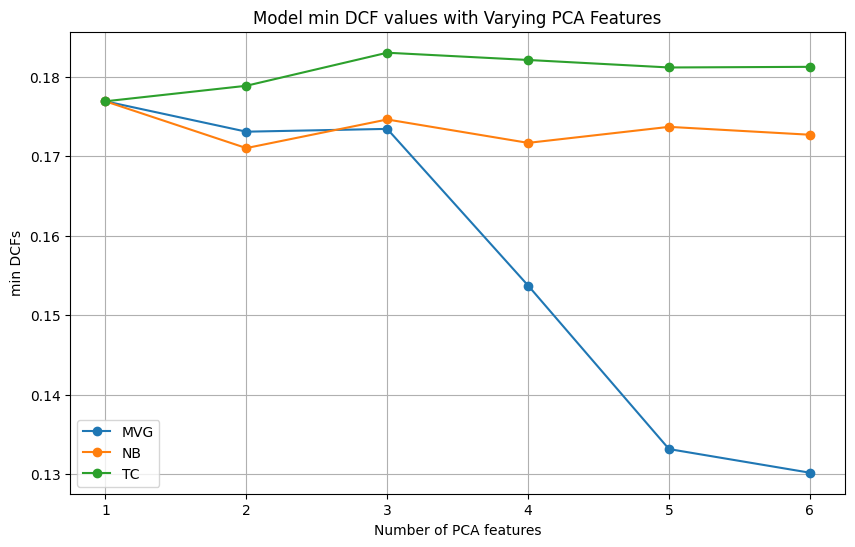

MVG - Best Accuracy: (6, 0.935, 0.13016833077316947)
NB - Best Accuracy: (2, 0.9145, 0.1710189452124936)
TC - Best Accuracy: (1, 0.9115, 0.17690732206861237)


In [14]:
pi = 0.5
res = compute_accuracy_model_pca(X_train, y_train, X_test, y_test, models_dict, pi)
for model_name, acc in res.items():
    print(f'{model_name} - Best Accuracy: {max(acc, key=lambda x: x[1])}')

In [15]:
for model_name, acc in res.items():
    print(f'{model_name} - Best minDCF: {min(acc, key=lambda x: x[2])}')

MVG - Best minDCF: (6, 0.935, 0.13016833077316947)
NB - Best minDCF: (2, 0.9145, 0.1710189452124936)
TC - Best minDCF: (1, 0.9115, 0.17690732206861237)


Model: MVG, PCA features: 6
	minDCF: 0.3423, DCf: 0.0400, DCF_norm: 0.4001, accuracy: 89.70%, threshold: -1.6198

Model: NB, PCA features: 6
	minDCF: 0.4359, DCf: 0.0451, DCF_norm: 0.4512, accuracy: 88.20%, threshold: -1.4419

Model: TC, PCA features: 6
	minDCF: 0.4421, DCf: 0.0463, DCF_norm: 0.4626, accuracy: 84.75%, threshold: -2.0126

Model: MVG, PCA features: 5
	minDCF: 0.3512, DCf: 0.0398, DCF_norm: 0.3980, accuracy: 89.65%, threshold: -1.6358

Model: NB, PCA features: 5
	minDCF: 0.4340, DCf: 0.0466, DCF_norm: 0.4660, accuracy: 87.90%, threshold: -1.5653

Model: TC, PCA features: 5
	minDCF: 0.4451, DCf: 0.0463, DCF_norm: 0.4626, accuracy: 84.60%, threshold: -2.0337

Model: MVG, PCA features: 4
	minDCF: 0.4150, DCf: 0.0460, DCF_norm: 0.4598, accuracy: 88.45%, threshold: -1.5366

Model: NB, PCA features: 4
	minDCF: 0.4313, DCf: 0.0463, DCF_norm: 0.4630, accuracy: 87.25%, threshold: -1.7147

Model: TC, PCA features: 4
	minDCF: 0.4441, DCf: 0.0462, DCF_norm: 0.4615, accuracy: 84.65%, 

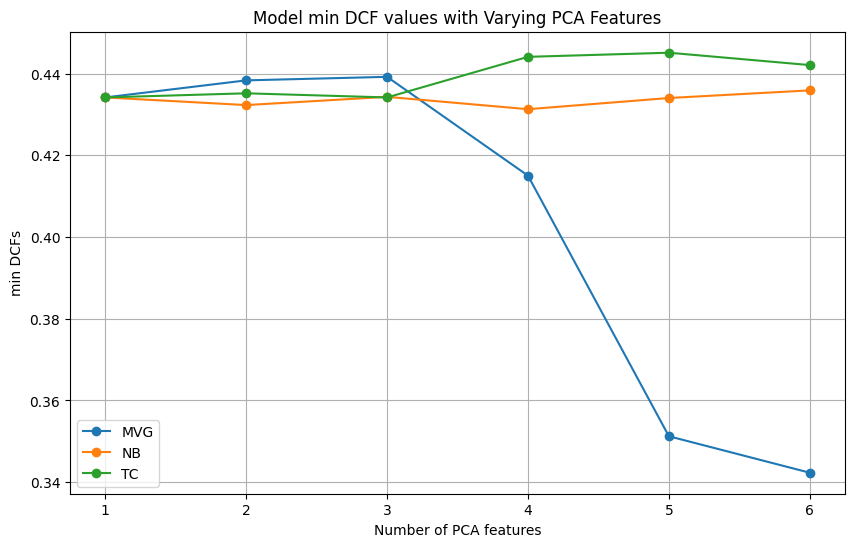

MVG - Best Accuracy: (6, 0.897, 0.34230990783410137)
NB - Best Accuracy: (6, 0.882, 0.43591589861751157)
TC - Best Accuracy: (6, 0.8475, 0.4421082949308756)


In [16]:
pi = 0.9
res = compute_accuracy_model_pca(X_train, y_train, X_test, y_test, models_dict, pi)
for model_name, acc in res.items():
    print(f'{model_name} - Best Accuracy: {max(acc, key=lambda x: x[1])}')

In [17]:
for model_name, acc in res.items():
    print(f'{model_name} - Best minDCF: {min(acc, key=lambda x: x[2])}')

MVG - Best minDCF: (6, 0.897, 0.34230990783410137)
NB - Best minDCF: (4, 0.8725, 0.431307603686636)
TC - Best minDCF: (3, 0.8475, 0.4341877880184332)


#### Best Model with the lowest minimum DCF: MVG with PCA 6

Model: MVG
	minDCF: 0.2629, DCf: 0.0305, DCF_norm: 0.3051, accuracy: 89.60%, threshold: 1.5372



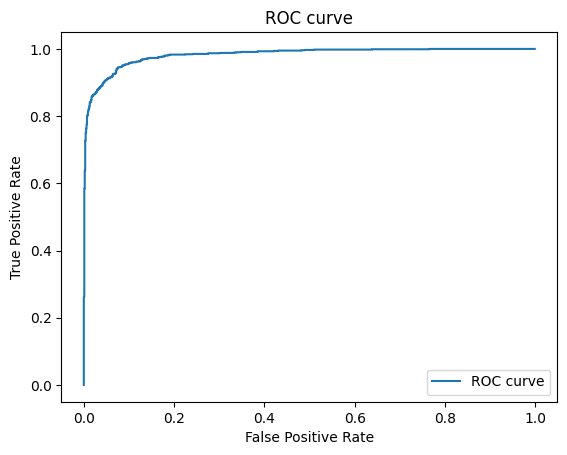

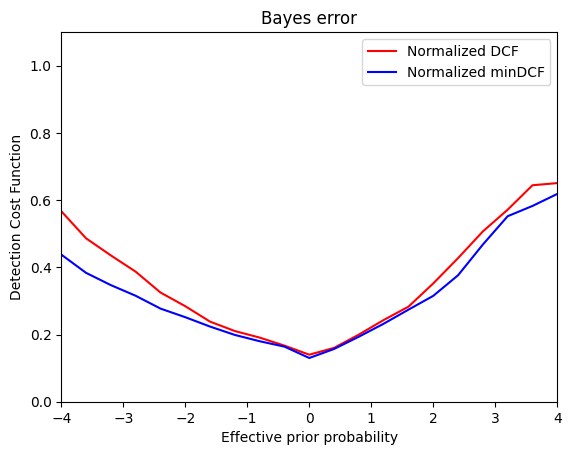

Model: NB
	minDCF: 0.3535, DCf: 0.0392, DCF_norm: 0.3920, accuracy: 85.85%, threshold: 1.8433



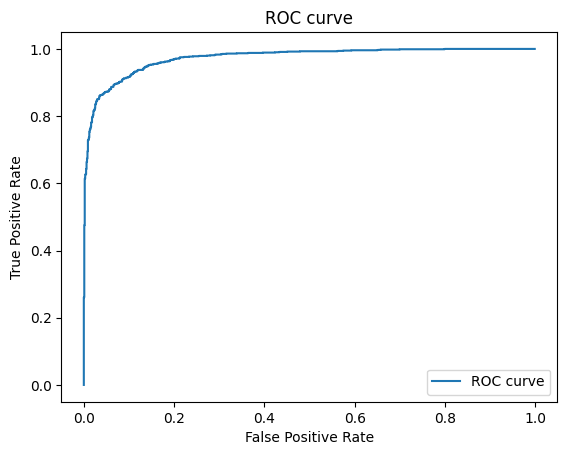

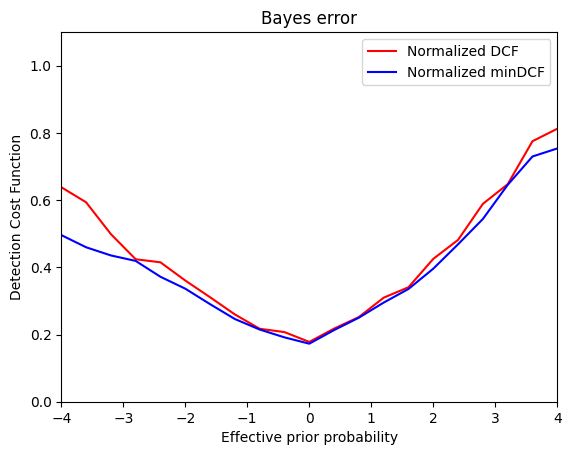

Model: TC
	minDCF: 0.3628, DCf: 0.0406, DCF_norm: 0.4061, accuracy: 86.60%, threshold: 1.7163



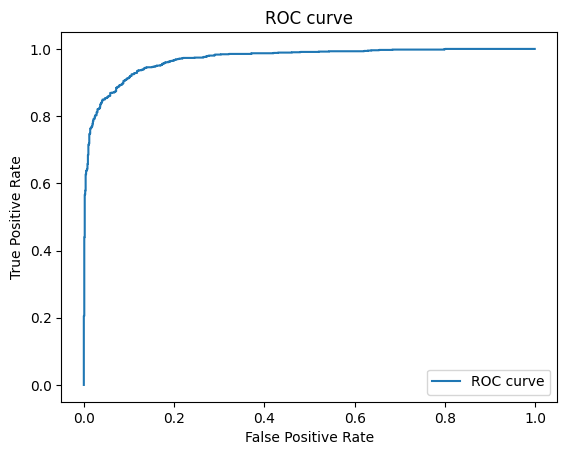

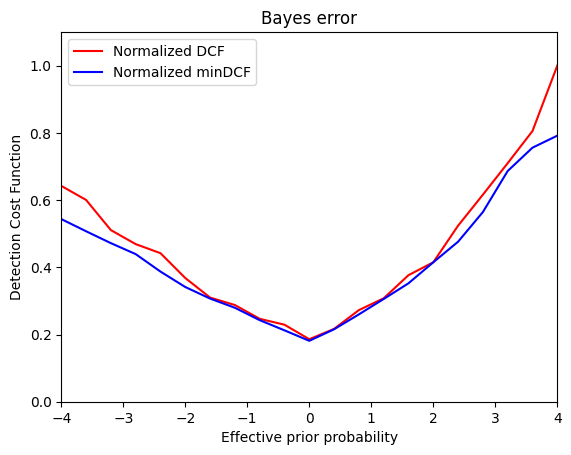

In [18]:
pi = 0.1

X_train, y_train, X_test, y_test = utils.split_data(X, y)
X_train_pca, eig_v = pp.pca(data=X_train, n_features=6, required_eigen_vectors=True)
X_test_pca = np.dot(eig_v.T, X_test)

models = {
    'MVG': MultivariateGaussianClassifier(),
    'NB': NaiveBayesClassifier(),
    'TC': TiedCovarianceClassifier(),
}

for model_name, model in models.items():
    print(f"Model: {model_name}")
    model.set_prior(pi)
    model.fit(X_train_pca, y_train)
    llr = model.score_binary(X_test_pca, y)
    compute_statistics(llr, y_test, pi, unique_labels=np.unique(y), plot_graph=True)